In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

import config
from models.coordinate import Coordinate


In [2]:
def read_data(file_path):
    list_cities = [None]

    with open(file_path, 'r') as f:
        data = f.readlines()
        NUMBER_CITIES = int(data[3].split(':')[-1].strip())

        for line in data[6: 6 + NUMBER_CITIES]:
            _, x, y = list(map(int, line.split()))
            list_cities.append(Coordinate(x, y))

    return list_cities, NUMBER_CITIES


list_cities, NUMBER_CITIES = read_data(config.DATA_PATH)
print(list_cities, NUMBER_CITIES)


[None, Coordinate(x=37, y=52), Coordinate(x=49, y=49), Coordinate(x=52, y=64), Coordinate(x=20, y=26), Coordinate(x=40, y=30), Coordinate(x=21, y=47), Coordinate(x=17, y=63), Coordinate(x=31, y=62), Coordinate(x=52, y=33), Coordinate(x=51, y=21), Coordinate(x=42, y=41), Coordinate(x=31, y=32), Coordinate(x=5, y=25), Coordinate(x=12, y=42), Coordinate(x=36, y=16), Coordinate(x=52, y=41), Coordinate(x=27, y=23), Coordinate(x=17, y=33), Coordinate(x=13, y=13), Coordinate(x=57, y=58), Coordinate(x=62, y=42), Coordinate(x=42, y=57), Coordinate(x=16, y=57), Coordinate(x=8, y=52), Coordinate(x=7, y=38), Coordinate(x=27, y=68), Coordinate(x=30, y=48), Coordinate(x=43, y=67), Coordinate(x=58, y=48), Coordinate(x=58, y=27), Coordinate(x=37, y=69), Coordinate(x=38, y=46), Coordinate(x=46, y=10), Coordinate(x=61, y=33), Coordinate(x=62, y=63), Coordinate(x=63, y=69), Coordinate(x=32, y=22), Coordinate(x=45, y=35), Coordinate(x=59, y=15), Coordinate(x=5, y=6), Coordinate(x=10, y=17), Coordinate(x=2

In [3]:
def init_population():
    population = [None]

    for _ in range(1, config.POPULATION_SIZE + 1):
        while True:
            individual = random.sample(
                range(1, NUMBER_CITIES + 1), NUMBER_CITIES)
            assert len(set(individual)) == NUMBER_CITIES
            if individual not in population:
                population.append(individual)
                break
        
    return population


population = init_population()


In [11]:
def euclidean_distance(index_city1, index_city2):
    if index_city1 == index_city2:
        return 0

    return np.linalg.norm((list_cities[index_city1].x - list_cities[index_city2].x,
                           list_cities[index_city1].y - list_cities[index_city2].y))


DISTANCE_MATRIX = [[None] * (NUMBER_CITIES + 1)] * (NUMBER_CITIES + 1)
for i in range(1, NUMBER_CITIES + 1):
    for j in range(1, NUMBER_CITIES + 1):
        DISTANCE_MATRIX[i][j] = euclidean_distance(i, j)

print(DISTANCE_MATRIX[0][1])


def cost(individual):
    c = 0

    for i in range(len(individual)):
        if i == len(individual) - 1:
            c += DISTANCE_MATRIX[individual[i]][individual[0]]
            # c += euclidean_distance(individual[i], individual[0])
        else:
            c += DISTANCE_MATRIX[individual[i]][individual[i+1]]
            # c += euclidean_distance(individual[i], individual[i+1])

    return c


def find_best(population):
    assert population[0] == None

    best_individual = population[1]
    best_cost = cost(population[1])

    for individual in population[2:]:
        tmp_cost = cost(individual)
        if tmp_cost < best_cost:
            best_individual = individual
            best_cost = tmp_cost

    return best_individual, best_cost


In [12]:
def select_parents(population):

    candidates = random.sample(population[1:], 4)

    return (candidates[0] if cost(candidates[0]) < cost(candidates[1]) else candidates[1],
            candidates[2] if cost(candidates[2]) < cost(candidates[3]) else candidates[3])


def select_cut_points(parent):
    pos1, pos2 = tuple(random.sample(range(len(parent)), 2))

    return (pos1, pos2) if pos1 > pos2 else (pos2, pos1)


In [13]:
def exec_cross(parent1, parent2, pos1, pos2):
    child = parent1[pos1: pos2 + 1]
    
    tmp = []
    for i in range(pos2 + 1, pos2 + 1 + len(parent2)):
        if i >= len(parent2):
            i %= len(parent2)
        if parent2[i] not in child:
            tmp.append(parent2[i])

    return (tmp[-pos1:] if pos1 != 0 else []) + child + tmp[:len(tmp) - pos1]


def crossover(parents):
    if random.random() < config.P_CROSSOVER:
        pos1, pos2 = select_cut_points(parents[0])

        children = []
        children.append(exec_cross(parents[0], parents[1], pos1, pos2))
        children.append(exec_cross(parents[1], parents[0], pos1, pos2))

        return tuple(children)

    return None, None

def circle_crossover(parents):
    pass
    

In [14]:
def mutation(parents):
    if random.random() < config.P_MUTATION:
        children = []
        for parent in parents:
            pos1, pos2 = select_cut_points(parent)

            parent[pos1], parent[pos2] = parent[pos2], parent[pos1]
            children.append(parent)

        return tuple(children)

    return None, None


In [15]:
def gen_offspring(population):
    offspring = [None]

    while len(offspring) < len(population):
        parents = select_parents(population)

        children_cross = crossover(parents)
        if children_cross != (None, None):
            for child in children_cross:
                offspring.append(child)
            # Mutation if only crossover
            children_multa = mutation(children_cross)
            if children_multa != (None, None):
                for child in children_multa:
                    offspring.append(child)

    assert len(offspring) >= len(population)
    random_index_remove = random.randint(1, len(offspring) - 1)
    offspring[random_index_remove], best_cost = find_best(population)

    return offspring, best_cost


In [16]:
history = [None]

for i in tqdm(range(config.NUM_GENERATIONS)):
    offspring, best_cost = gen_offspring(population)
    history.append(best_cost)
    population = offspring

100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


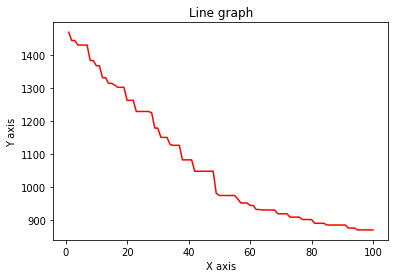

In [17]:
plt.title("Line graph")
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.plot(range(1, len(history)), list(map(lambda x: x, history[1:])), color ="red")
plt.show()